In [74]:
from utils.dataset import load_dataset
import numpy as np
from sklearn.preprocessing import MinMaxScaler, StandardScaler
import tsgm
dataset_name = "Chinatown"
data = load_dataset(dataset_name, "TRAIN")
ts_data = data.iloc[:,1:]
ts_data = ts_data.to_numpy(dtype=np.float32)
org_data_shape = ts_data.shape
N  = org_data_shape[0]
T = org_data_shape[1]

scaler_minmax = True

if scaler_minmax:
    scaler = MinMaxScaler()
    ts_data = scaler.fit_transform(ts_data)
ts_data = ts_data.reshape(N, T, 1)

if not scaler_minmax:
    scaler = tsgm.utils.TSFeatureWiseScaler()
    ts_data = scaler.fit_transform(ts_data)



ts_data.shape


(20, 24, 1)

In [75]:
import numpy as np
from sklearn.preprocessing import OneHotEncoder
data = load_dataset(dataset_name, "TRAIN")

# Suppose labels is a 1D array of length N
labels = data.iloc[:, 0].to_numpy()  # shape (N,)
unique_labels = np.unique(labels)
num_classes = len(unique_labels)

enc = OneHotEncoder()
labels = enc.fit_transform(labels.reshape(-1, 1)).toarray()
labels = np.array(labels,dtype=np.float32)
(ny, y) = labels.shape
# Initialize encoder (dense output for simplicity)
labels.shape

(20, 2)

In [76]:
import tsgm


seq_len = T
feat_dim = 1
latent_dim = 4
output_dim = y
model_type = tsgm.models.architectures.zoo["cvae_conv5"]
arch = model_type(
    seq_len=seq_len, feat_dim=feat_dim,
    latent_dim=latent_dim, output_dim=output_dim)
arch_dict = arch.get()

encoder, decoder = arch_dict["encoder"], arch_dict["decoder"]




cBetaVae = tsgm.models.cvae.cBetaVAE(encoder=encoder, decoder=decoder,latent_dim=latent_dim, beta=1,temporal=False)

cBetaVae.compile(optimizer="adam")

In [77]:
cBetaVae.fit(x=ts_data,y=labels, epochs=30, batch_size=3)


Epoch 1/30
7/7 [==============================] - 1s 4ms/step - loss: 12.4826 - reconstruction_loss: 13.1792 - kl_loss: 0.0052
Epoch 2/30
7/7 [==============================] - 0s 4ms/step - loss: 12.7495 - reconstruction_loss: 13.0433 - kl_loss: 3.9053e-04
Epoch 3/30
7/7 [==============================] - 0s 4ms/step - loss: 13.2350 - reconstruction_loss: 12.8618 - kl_loss: 1.5375e-04
Epoch 4/30
7/7 [==============================] - 0s 4ms/step - loss: 12.9704 - reconstruction_loss: 12.5623 - kl_loss: 1.0134e-04
Epoch 5/30
7/7 [==============================] - 0s 5ms/step - loss: 13.4458 - reconstruction_loss: 12.0521 - kl_loss: 2.2876e-04
Epoch 6/30
7/7 [==============================] - 0s 4ms/step - loss: 11.4726 - reconstruction_loss: 11.0874 - kl_loss: 6.2138e-04
Epoch 7/30
7/7 [==============================] - 0s 4ms/step - loss: 10.9865 - reconstruction_loss: 9.9582 - kl_loss: 0.0015
Epoch 8/30
7/7 [==============================] - 0s 4ms/step - loss: 10.6957 - reconstructi

In [78]:
nr_samples = 10
from tsgm.types import Tensor
import tensorflow as tf

num_classes = num_classes
per_class = nr_samples // num_classes

def distribute_items(n, k):
    """Distribute n items across k bags as evenly as possible"""
    return np.array_split(range(n), k)

def distribute_counts(n, k):
    """Get just the counts per bag"""
    return [len(bag) for bag in distribute_items(n, k)]

all_samples = []

for i, samples in enumerate(distribute_counts(nr_samples, num_classes)):
    for _ in range(samples):
        one_hot = [0.0 for _ in range(num_classes)]
        one_hot[i] = 1.0
        all_samples.append(one_hot)

tensor = tf.convert_to_tensor(all_samples)


gen_samples, gen_label = cBetaVae.generate(tensor)


In [79]:

gen_data = np.array(gen_samples)
print(gen_data.shape)
if scaler_minmax:
    gen_data = gen_data.reshape(nr_samples,T)
gen_data = scaler.inverse_transform(gen_data)

print(gen_data.shape)

if not scaler_minmax:
    gen_data = gen_data.reshape(nr_samples,T)



(10, 24, 1)
(10, 24)


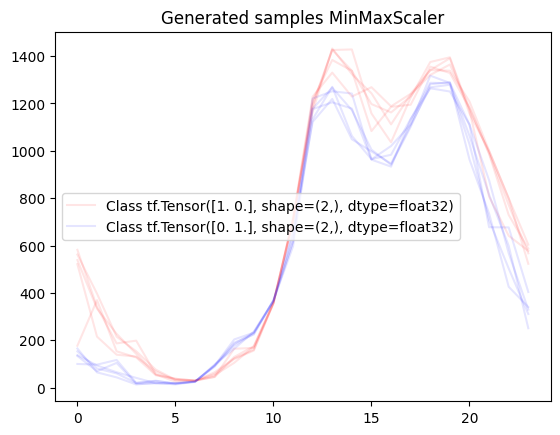

In [80]:
from matplotlib import pyplot as plt

c_to_col = {}
for ts,c in zip(gen_data, gen_label):
    bool_first = False
    if str(c) not in c_to_col:
        c_to_col[str(c)] = "red" if len(c_to_col) == 0 else "blue"
        bool_first = True
    plt.plot(ts, alpha=0.1, color=c_to_col[str(c)], label="Class " + str(c) if bool_first else "")

method = "MinMaxScaler" if scaler_minmax else "TSFeatureWiseScaler"
plt.legend()
plt.title("Generated samples "  + method)
plt.show()


In [60]:
import tsgm
tsgm.models.zoo.summary()

+-----------------+---------------------------+
|        id       |            type           |
+-----------------+---------------------------+
|    vae_conv5    |     vae:unconditional     |
|    cvae_conv5   |      vae:conditional      |
| cgan_base_c4_l1 |      gan:conditional      |
|    t-cgan_c4    |     gan:t-conditional     |
|   cgan_lstm_n   |      gan:conditional      |
|   cgan_lstm_3   |      gan:conditional      |
|      clf_cn     | downstream:classification |
|     clf_cl_n    | downstream:classification |
|    clf_block    | downstream:classification |
|    recurrent    |      rnn_architecture     |
| clf_transformer | downstream:classification |
+-----------------+---------------------------+
